In [1]:
%matplotlib inline

import pydot
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import chain
from IPython.display import Image

import math, os, sys
sys.path.append("pywnxml")

from WNQuery import WNQuery

In [2]:
with open(os.devnull, 'w') as devnull:
    wn = WNQuery("plwordnet-3.2-visdisc.xml", devnull)

### Znaczenia rzeczownika _szkoda_ i ich synonimy

In [3]:
def list_meanings_and_synonyms(word):
    def meaning_no(synset):
        for synonym in synset.synonyms:
            if synonym.literal == word:
                return int(synonym.sense)

    synsets = wn.lookUpLiteral(word, "n")
    synsets = sorted(synsets, key=meaning_no)
    for synset in synsets:
        print("{}. '{}'".format(meaning_no(synset), synset.definition))
        for synonym in synset.synonyms:
            if synonym.literal != word:
                print("    - {} ({})".format(synonym.literal, synonym.sense))

In [4]:
list_meanings_and_synonyms("szkoda")

1. 'brak danych'
2. ''
    - strata (1)
    - utrata (1)
    - uszczerbek (1)


### Domknięcie przechodnie relacji _hiperonimi_ dla wyrażenia _wypadek drogowy (1)_

In [5]:
TRAFFIC_ACCIDENT_ID = wn.lookUpSense("wypadek drogowy", 1, "n").wnid
TRAFFIC_ACCIDENT_ID

'PLWN-00410902-n'

In [6]:
def find_relation(relation, start_id):
    related = wn.lookUpRelation(start_id, "n", relation)
    res = set((start_id, rel_id) for rel_id in related)
    for rel_id in related:
        res |= find_relation(relation, rel_id)
    return res

def find_transitive_closure(relation):
    next_step = relation | set((x, z) for x, y in relation for y1, z in relation if y == y1)
    if next_step == relation:
        return relation
    else:
        return find_transitive_closure(next_step) 

In [7]:
relation = find_relation("hypernym", TRAFFIC_ACCIDENT_ID)
tclosure = find_transitive_closure(relation)

In [8]:
def mk_label_for(node):
    literal = wn.lookUpID(node, "n").synonyms[0].literal
    bound = len(node)
    
    res = node + "\n"
    while len(literal) > bound:
        res += literal[:bound-1] + "-\n"
        literal = literal[bound-1:]
    res += literal

    return res    

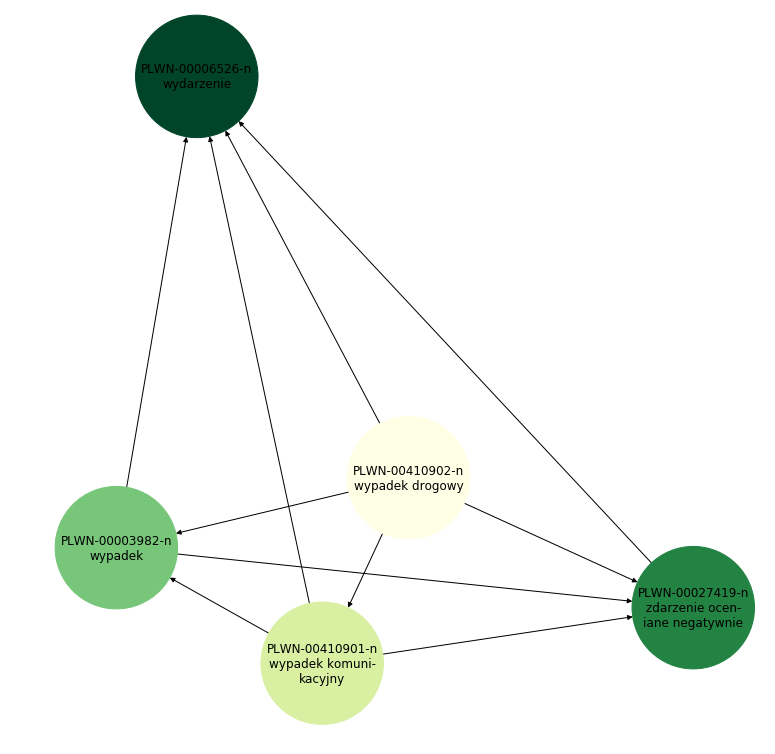

In [9]:
plt.figure(figsize=(10, 10))

DG = nx.DiGraph()
DG.add_edges_from(tclosure)

max_in_degree = max(DG.in_degree(v) for v in DG.nodes())

labels = {v: mk_label_for(v) for v in DG.nodes()}
node_color = [DG.in_degree(v) / max_in_degree for v in DG.nodes()]

pos = nx.spring_layout(DG)
nx.draw(DG, pos, node_size=15000, labels=labels, node_color=node_color, cmap=plt.get_cmap("YlGn"))

### Bezpośrednie hiponimy rzeczownika _wypadek (1)_

In [10]:
ACCIDENT_ID = wn.lookUpSense("wypadek", 1, "n").wnid
ACCIDENT_ID

'PLWN-00003982-n'

In [11]:
def list_words(ids):
    for i, synonym in enumerate(wn.lookUpID(id, "n").synonyms[0] for id in ids):
        print("{}. {} ({})".format(i + 1, synonym.literal, synonym.sense))

In [12]:
ACCIDENT_DIRECT_HYPONYMS = wn.lookUpRelation(ACCIDENT_ID, "n", "hiponimia")

list_words(ACCIDENT_DIRECT_HYPONYMS)

1. kolizja (2)
2. tąpnięcie (1)
3. zawał (2)
4. zderzenie (2)
5. wykolejenie (2)
6. zakrztuszenie (1)
7. wypadek komunikacyjny (1)
8. katastrofa budowlana (1)
9. wypadek jądrowy (1)
10. karambol (1)
11. kapotaż (1)


### Hiponimy drugiego rzędu dla rzeczownika _wypadek (1)_

In [13]:
ACCIDENT_SECOND_ORDER_HYPONYMS = [id2
                                  for id1 in ACCIDENT_DIRECT_HYPONYMS
                                  for id2 in wn.lookUpRelation(id1, "n", "hiponimia")]

list_words(ACCIDENT_SECOND_ORDER_HYPONYMS)

1. kolizja drogowa (1)
2. obwał (1)
3. czołówka (9)
4. stłuczka (1)
5. wypadek drogowy (1)


### Relacje semantyczne pomiędzy grupami leksemów

In [14]:
def group_for(lexemes):
    return {(literal, sense): wn.lookUpSense(literal, sense, 'n') for literal, sense in lexemes}

def mk_lexemes_by_id_lookup(group):
    res = defaultdict(list)
    for lexeme, synset in group.items(): res[synset.wnid].append(lexeme)
    return dict(res)

In [15]:
REL_COLOR = {
    "hypernym": "red",
    "hyponym":  "blue",
    "synonym":  "green"
}

REL_LABEL = {
    "hypernym": "hiperonimia",
    "hyponym":  "hiponimia",
    "synonym":  "synonimia"
}

In [16]:
def format_lexeme(lexeme):
    return "{} ({})".format(lexeme[0], lexeme[1])

def mk_edge(lexeme1, lexeme2, relation):
    f1 = format_lexeme(lexeme1)
    f2 = format_lexeme(lexeme2)
    color = REL_COLOR[relation]
    label = REL_LABEL[relation]
    return (f1, f2, {"color": color})

def mk_legend():
    legend = pydot.Cluster(graph_name="legend", label="Legenda", rankdir="LR")
    for rel in REL_LABEL:
        node = pydot.Node(REL_LABEL[rel], shape="plaintext")
        legend.add_node(node)
        legend.add_edge(pydot.Edge(node, node, color=REL_COLOR[rel]))
    return legend

In [17]:
def find_relations_within(group):
    synsets = group.values()
    ids = [ss.wnid for ss in synsets]

    lexemes = mk_lexemes_by_id_lookup(group)

    synset_relations = (
        (rel, (lex1, lex2))
        for id1, ss in ((ss.wnid, ss) for ss in synsets)
        for id2, rel in ss.ilrs
        if id2 in ids
        for lex1 in lexemes[id1]
        for lex2 in lexemes[id2]
    )
    
    synonyms = (
        ("synonym", (lex1, lex2))
        for synonyms in lexemes.values()
        for lex1 in synonyms
        for lex2 in synonyms
        if lex1 != lex2
    )

    res = defaultdict(set)
    for rel, tup in chain(synonyms, synset_relations): res[rel].add(tup)
    return dict(res)

In [18]:
def draw_relations_graph(group, relations):
    edges = [
        mk_edge(lex1, lex2, rel)
        for rel, edges in relations.items()
        if rel != "hiponimia"
        for lex1, lex2 in edges
    ]
    
    G = nx.MultiDiGraph()
    G.add_edges_from(edges)
    
    G_pydot = nx.drawing.nx_pydot.to_pydot(G)    
    G_pydot.add_subgraph(mk_legend())

    return Image(data=G_pydot.create_png())

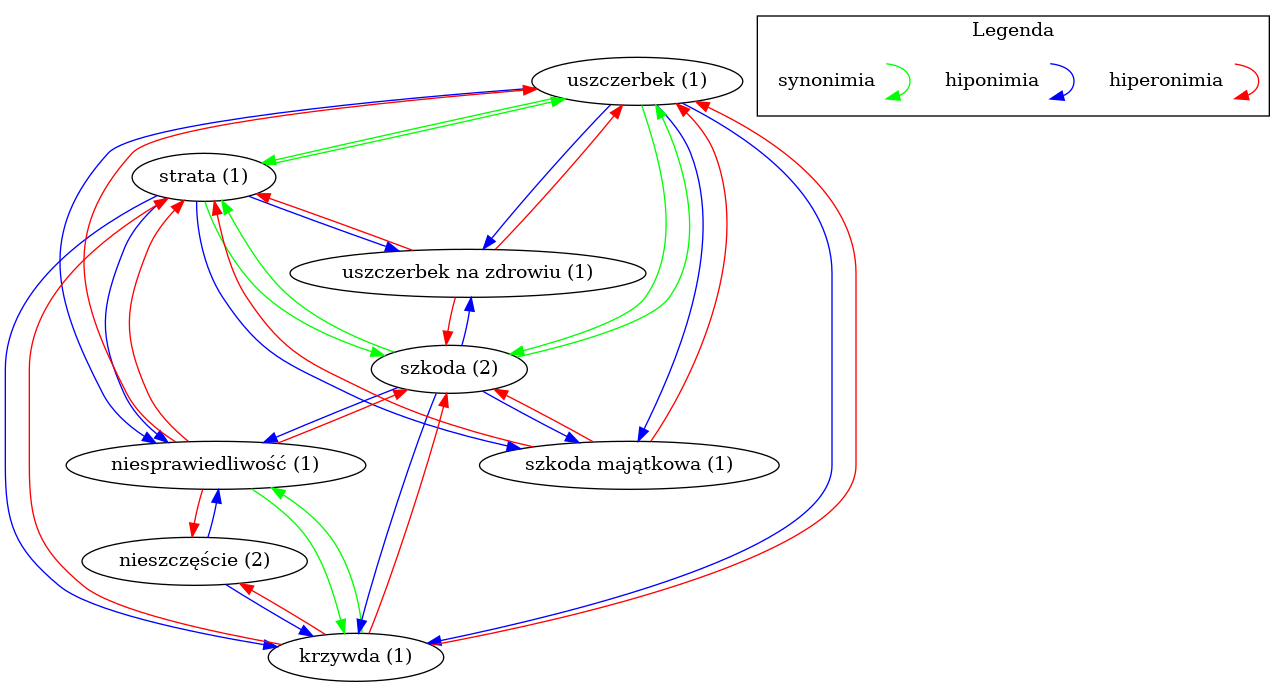

In [19]:
GROUP_1 = group_for([
    ("szkoda", 2),
    ("strata", 1),
    ("uszczerbek", 1),
    ("szkoda majątkowa", 1),
    ("uszczerbek na zdrowiu", 1),
    ("krzywda", 1),
    ("niesprawiedliwość", 1),
    ("nieszczęście", 2)
])

G1_RELATIONS = find_relations_within(GROUP_1)

draw_relations_graph(GROUP_1, G1_RELATIONS)

In [20]:
GROUP_2 = group_for([
    ("wypadek", 1),
    ("wypadek komunikacyjny", 1),
    ("kolizja", 2),
    ("zderzenie", 2),
    ("kolizja drogowa", 1),
    # ("bezkolizyjny", 2),
    ("katastrofa budowlana", 1),
    ("wypadek drogowy", 1)
])

G2_RELATIONS = find_relations_within(GROUP_2)

draw_relations_graph(GROUP_2, G2_RELATIONS)

### Miary pokrewieństwa semantycznego Leacocka-Chodorowa pomiędzy parami leksemów

In [21]:
NOUNS = {wnid for wnids in wn.m_nidx.values() for wnid in wnids}
len(NOUNS)

132398

In [22]:
def _max_depth(wnid):
    hyponyms = wn.lookUpRelation(wnid, 'n', "hyponym")
    if not hyponyms:
        return 0
    else:
        return 1 + max(_max_depth(h) for h in hyponyms)

MAX_DEPTH = 1 + max(_max_depth(n) for n in NOUNS)
MAX_DEPTH

35

In [23]:
def path_to_root(wnid, depth=0):
    hypernyms = wn.lookUpRelation(wnid, 'n', "hypernym")
    if not hypernyms:
        return {wnid: depth}
    else:
        res = {hh: d for h in hypernyms for hh, d in path_to_root(h, depth + 1).items()}
        res.update({wnid: depth})
        return res

def shortest_path_distance(wnid1, wnid2):
    path1 = path_to_root(wnid1)
    path2 = path_to_root(wnid2)
    
    inf = float("inf")
    dist = inf
    for wnid, d1 in path1.items():
        d2 = path2.get(wnid, inf)
        dist = min(dist, d1 + d2)
    
    return dist if not math.isinf(dist) else max(d for d in path1.values()) + max(d for d in path2.values())

In [24]:
def leacock_chodorow(lexeme1, lexeme2):
    synset1 = wn.lookUpSense(lexeme1[0], lexeme1[1], 'n')
    synset2 = wn.lookUpSense(lexeme2[0], lexeme2[1], 'n')

    distance = shortest_path_distance(synset1.wnid, synset2.wnid)

    if distance < 0:
        return None
    return -math.log((distance + 1) / (2.0 * MAX_DEPTH))

In [25]:
leacock_chodorow(("szkoda", 2), ("wypadek", 1))

2.8622008809294686

In [26]:
leacock_chodorow(("kolizja", 2), ("szkoda majątkowa", 1))

2.456735772821304

In [27]:
leacock_chodorow(("nieszczęście", 2), ("katastrofa budowlana", 1))

2.05127066471314